In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

from hcipy import *
# from Keck_aperture import *

%load_ext autoreload
%autoreload 2

In [2]:
pupil_diameter = 3.048 # (m)
collecting_area = np.pi*(3.048**2-0.9779**2)
f_number = 13 #effective focal ratio
effective_focal_length = pupil_diameter*f_number # (m)
filter_name = 'V'

# print(filters[filter_name])--> {'Flux0': 3.631e-09, 'lambda_eff': 0.545, 'delta_lambda': 0.085, 'photons0': 995.5}
wavelength=filters[filter_name]['lambda_eff']*1e-6 # (m)



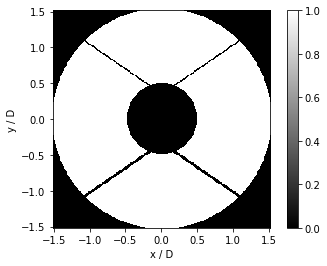

In [3]:
#setting up pupil grid, and setting spiders to match the lick telescope

grid_size = 250

pupil_grid = make_pupil_grid(grid_size, diameter = pupil_diameter)

#fixing spiders, applying make_lick_aperture to pupil_grid
telescope_pupil_generator = make_lick_aperture()
telescope_pupil = telescope_pupil_generator(pupil_grid)

#setting up image for pupil grid
im = imshow_field(telescope_pupil, cmap = 'gray')
plt.colorbar()
plt.xlabel('x / D')
plt.ylabel('y / D')
plt.show()

In [4]:
#seeing estimated from this source: https://mthamilton.ucolick.org/techdocs/MH_weather/obstats/avg_seeing.html
seeing = 1.75
outer_scale = 40 # (m) , this is a guess that needs to be refined
velocity = 20 #(m/s) - another guess needing to be refined

#   fried_parameter <-eqv-> r0 ; r0 is the length scale over which the phase changes by < 1 radian, 
#   also the characteristic size of turbulent cells
fried_parameter = seeing_to_fried_parameter(seeing, 500e-9)

#refractive index structure constant, describes intensity of atmospheric turbulence
#  (fnc:Cn_squared_from_fried_parameter) 
#      -->parameters: (r0, wavelength)
#      -->returns: scalar, integrated Cn^2 for a certain Fried par.
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)

# tau0 - timescale over which the phase changes by < 1 radian, [tau0≈ 0.314 * r0/v]
tau0 = 0.314 * fried_parameter/velocity

print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
print('L0 = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v0 = {0:.1f}m/s'.format(velocity))




r0   = 5.8cm
L0 = 40.0m
tau0 = 0.9ms
v0 = 20.0m/s


In [5]:
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

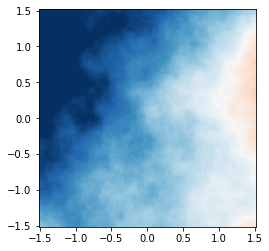

In [6]:
# setting up the phase screen, each atmospheric layer will be modelled as an infinitely-thin phase screen
# used to simulate turbulance
phase_screen_phase = layer.phase_for(wavelength) #(radians)
phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6

# note parameters: vmin,vmax are scalars, max and min values of the colorbar
imshow_field(phase_screen_opd, vmin= - 2*np.pi, vmax= 2*np.pi, cmap ='RdBu')


## Propagating to the focal plane

In [7]:
nairy = 100
# makes a grid for the focal plane
focal_grid = make_focal_grid(q=4,
                            num_airy=nairy,
                            pupil_diameter=pupil_diameter,
                            focal_length=effective_focal_length,
                            reference_wavelength=wavelength)

# (fnc: FraunhoferPropagator) implements propagation of a wavefront thru a perfect lens, exactly in the 
#                             front focal plane of lens
#   --> parameters: (input_grid, output_grid, focal_length)
prop = FraunhoferPropagator(pupil_grid, focal_grid,
                            focal_length=effective_focal_length)


## Pick target properties

In [8]:
mag = 17 #Vega magnitude in the band of interest
stokes_vector = [1,0.,0.,0.]
    #note: Q, U, V = 0. , light here is unpolarized
exposure_time = 0.01 #exposure time in seconds

pupil_wavefront = Wavefront(telescope_pupil, wavelength, input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag, filter_name, collecting_area) #(in photons/s)
print(filters[filter_name]['delta_lambda'])
#print(collecting_area, number_of_photons(mag, filter_name,collecting_area ))

print(collecting_area,pupil_wavefront.total_power )

0.085
26.182082152446807 35112.7117532779


## Add a companion

In [9]:
contrast = 0.
stokes_ps = [1,0.,0.,0.] #these are I, Q, U, V
angular_separation = 2 #Lambda/D

#(fnc: Wavefront)
    #par: electric_field, wavelength, input_stokes_vector
    #represents the state of light to be propagated through the optical system
wf_planet = Wavefront(telescope_pupil*
                             np.exp(4j* np.pi * pupil_grid.x* angular_separation/ pupil_diameter),
                            wavelength, input_stokes_vector=stokes_ps)
wf_planet.total_power = number_of_photons(mag, filter_name, collecting_area)*contrast #In (photons/s)


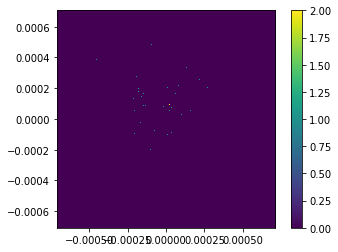

In [10]:
pupil_wavefront = Wavefront(telescope_pupil, wavelength, input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag, filter_name, collecting_area) # in (photons/s)
#print(mag)

#(fnc: NoisyDetector) a detector class that has some basic noise properties 
detector = NoisyDetector(focal_grid, dark_current_rate=0, read_noise = 0, flat_field = 0, include_photon_noise=True)

#this all generates what the image looks like for the set seeing conditions, magnitude, angular sep. etc, 
#..integrates detector read out over set exposure time to produce image


from utils import supergauss_hw

#the set range (100 below) determines how many images to integrate, more is better (though more time consuming),
#bc you need enough exposures so that your speckles change enough so they get washed out from your Fourier transform

layer.t = 0.1
for i in range(100):
    layer.t+exposure_time
# (fnc: detector.integrate)
#   --> parameters: wavefront, sets amt of power generated per unit time ; dt, integration time in units of time
    detector.integrate(prop(layer(pupil_wavefront)), exposure_time)
    detector.integrate(prop(layer(wf_planet)),exposure_time)
    image_comb = detector.read_out()
    #print(np.max(image_comb))

    npix = int(np.sqrt(len(image_comb)))

    im_ft = image_comb.reshape([npix, npix])
    
    
    if i == 0 : sg = supergauss_hw(100, 4, npix)
    
#(fnc: np.fft.fftshift) --> shifts the zero-frequency component to the center of the spectrum
    #par: x; input array
#(fnc: np.fft.fft2) --> computes the 2-dimensional (last two axes of input array) discrete Fourier Transform
    FT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_ft*sg)))
#PS - abs. value of FT^2
    PS = np.abs(FT/FT[int(npix/2), int(npix/2)])**2
    
    if i == 0:
        PS_all = np.array(PS)
    else:
        PS_all+=PS

imshow_field(image_comb)
plt.colorbar()
plt.show()
    
#ACF is the FT of your PS

ACF = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(PS_all)))

99.99999999999999


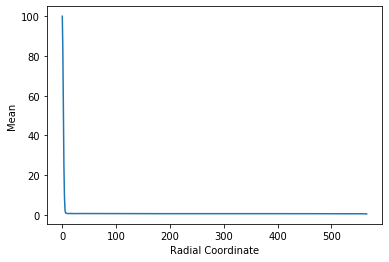

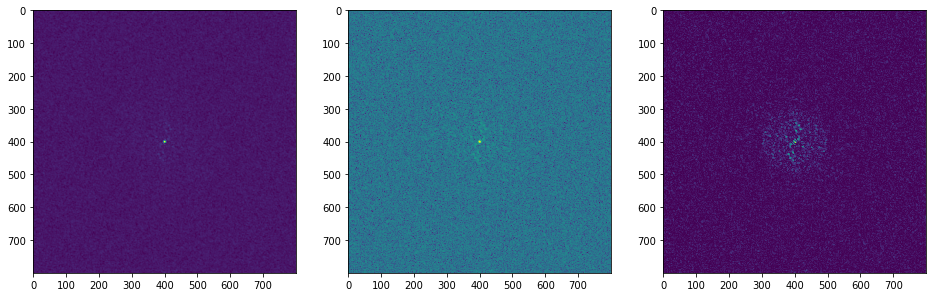

In [11]:
PS_all_bsub = PS_all.copy()
PS_all_bsub -= np.mean(PS_all[700:,700:])

#(Tokovinin speckle paper) removing wide seeing pedestal leads to "ringing" in ACF, this is avoided by dividing..
#..the PS by its azimuthal average

###divide PS by azimuthal average at low frequencies (f < 0.2 fc = 0.2 D / lambda)
from radial_profile import radial_data

rad_stats = radial_data(PS_all)
plt.figure()
plt.plot(rad_stats.r, rad_stats.mean)
plt.xlabel('Radial Coordinate')
plt.ylabel('Mean')

#scaling: 
plate_scale = 0.25 * 550. * 10**-9 / pupil_diameter * 206265   ###plate scale of image in (arcsec / pixel)
###grid is 800 pixels across, equalling 200 lambda / D, plate scale is then 0.25*(lambda / D per pixel)

ps_mpp = 1. / (npix * plate_scale) * 206265. * 550 * 10**-9 #plate scale of FT in (meters/pixel)
scaling = 0.5
fcut = pupil_diameter / ps_mpp * scaling
print(fcut)



PS_all_filt = PS_all_bsub.copy()

#running through pixels through a certain radius range and determining how far it is from the closest value in rad.profile
for xx in range(len(PS_all_filt)):
    for yy in range(len(PS_all_filt)):
        rad = np.sqrt((xx-npix/2)**2+(yy-npix/2)**2)
        if rad < fcut:
            drad = rad_stats.r-rad
            val = rad_stats.mean[np.where(np.abs(drad)==np.min(np.abs(drad)))][0]
            PS_all_filt[yy,xx]/=val


f = plt.figure(figsize=(16,10))
f.add_subplot(131)
plt.imshow(np.abs(PS_all)**0.1)
f.add_subplot(132)
plt.imshow(np.abs(PS_all_bsub)**0.1)
f.add_subplot(133)
plt.imshow(np.abs(PS_all_filt))
plt.show()

#this is the filtered ACF, no seeing pedestal --> take the FT of filtered PS
ACF_filt = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(PS_all_filt)))

ACF_filt_norm = ACF_filt / ACF_filt[int(npix/2), int(npix/2)]



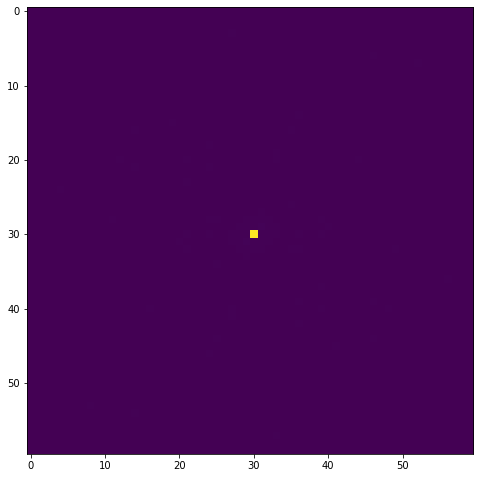

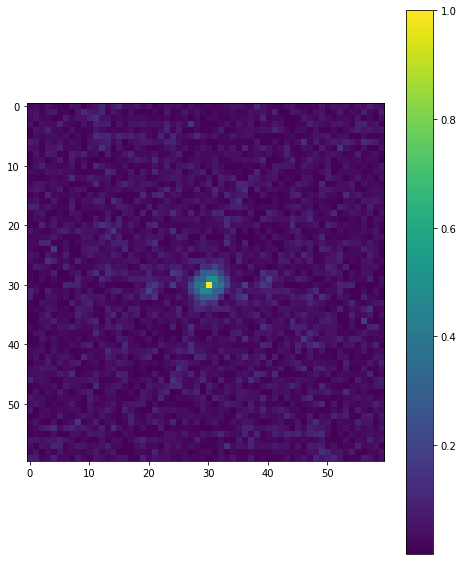

In [12]:
#plotting ACF vs filtered normalized ACF
fsub = 30
f = plt.figure(figsize=(8,10))
plt.imshow(np.abs(ACF)[int(npix/2)-fsub:int(npix/2)+fsub,int(npix/2)-fsub:int(npix/2)+fsub])
plt.show()

f = plt.figure(figsize=(8,10))
plt.imshow(np.abs(ACF_filt_norm)[int(npix/2)-fsub:int(npix/2)+fsub,int(npix/2)-fsub:int(npix/2)+fsub])
plt.colorbar()
plt.show()

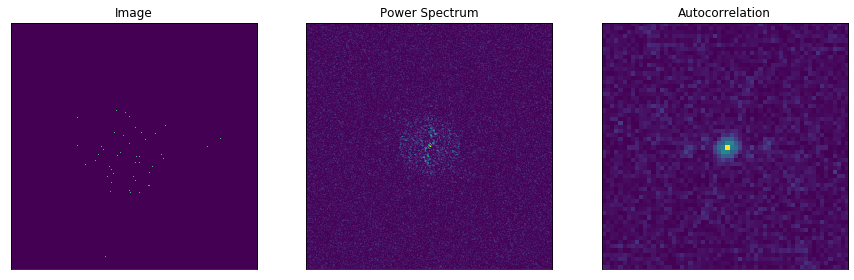

In [13]:
#plotting the image, PS, and ACF
f = plt.figure(figsize=(15,5))

ax=f.add_subplot(131)
plt.imshow(im_ft**0.5)
ax.set_yticks([])
ax.set_xticks([])
plt.title('Image')

ax = f.add_subplot(132)
plt.title('Power Spectrum')
plt.imshow(np.abs(PS_all_filt))
ax.set_yticks([])
ax.set_xticks([])

ax=f.add_subplot(133)
plt.imshow(np.abs(ACF_filt_norm)[int(npix/2)-fsub:int(npix/2)+fsub,int(npix/2)-fsub:int(npix/2)+fsub])
ax.set_yticks([])
ax.set_xticks([])
plt.title('Autocorrelation')

plt.show()

In [14]:
def ACF_cc(ACF):
    return -2.5 * np.log10((1-np.sqrt(1-(2*ACF)**2))/(2*ACF))

/Users/Nicole/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


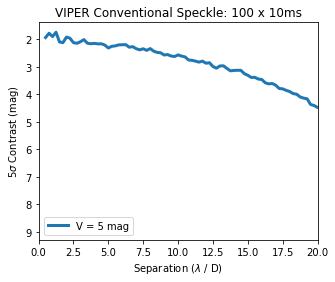

In [15]:
ACF_m = ACF_cc(ACF_filt_norm)


rad_ACF = radial_data(np.abs(ACF_filt_norm), annulus_width = 2)

cc = ACF_cc(5 * rad_ACF.std)

xax = np.array(range(len(rad_ACF.mean))) * plate_scale / ((550. * 10**-9) / pupil_diameter * 206265) #in units of (lamda/D)

f = plt.figure(figsize = (5,4))
plt.plot(xax, cc, label='V = 5 mag', lw=3)
plt.xlim(0.0,20.0)

plt.gca().invert_yaxis()
plt.legend(loc='lower left')
plt.ylabel(r'5$\sigma$ Contrast (mag)')
plt.xlabel(r'Separation ($\lambda$ / D)')
plt.title('VIPER Conventional Speckle: 100 x 10ms')

plt.show()


## Speckle Polarimetry Analysis

In [16]:
#ratio R of the visibilities in two orthogonal polatiztions
#defining R_U, the differential polarimetric visibility for Stokes U (diagonal polarizations)

def R_U(f_L, f_R, N_e, theta, h):
    #f_L: left side of FTs (numpy array of images)
    #f_R: right side of FTs (numpy array of images)
    #rho_L: phase slope for left side
    #rho_R: phase slope for right side
    #fs: spatial frequencies that go with FTs
    #N_e: the avg number of photons in a single frame
    #theta: HWP angle (measured in deg)
##T accounts for the difference in the displacements of the L and R beams of the polarimeter
    #T = np.exp(2.0 * np.pi * 1.0j * fs * (rho_R - rho_L))

    thetas = np.ones(f_L.shape)
    for x in range(len(thetas)):
        thetas[x] = thetas[x]*theta[x]
#numerator and denomenator of R_U expression, eqn.3 from SPIE 2020, Safonov

    num = np.mean((f_L - f_R) * (f_L + f_R).conj() * np.sin(h*np.radians(thetas)), axis=0)
    den = np.mean((f_L + f_R) * (f_L + f_R).conj(), axis=0) - 1.0/N_e
    R_U = 1.0 + num/den
    return(R_U)

#defining R_Q, the differential polarimetric visibility for Stokes Q (vertical & horizontal polarizations)
#R_U vs R_Q --> *sin(h*theta) vs cos(h*theta)

def R_Q(f_L,f_R,N_e,theta,h):
    #f_L: left side FTs (numpy array of images)
    #f_R: right side FTs (numpy array of images)
    #rho_L: phase slope for left side
    #rho_R: phase slope for right side
    #fs: spatial frequencies that go with FTs
    #N_e: avg number of photons in a single frame
    #theta: HWP angle (measured in deg)
    
    #T = np.exp(2.0*np.pi*1.0j*fs*(rho_R - rho_L))
    #num=np.mean((T*f_L - f_R)*(T*f_L + f_R).conj()*np.cos(h*np.radians(theta)),axis=0)
    #den=np.mean((T*f_L + f_R)*(T*f_L + f_R).conj(),axis=0) - 1.0/N_e
    thetas = np.ones(f_L.shape)
    for x in range(len(thetas)):
        thetas[x] = thetas[x]*theta[x]
    num=np.mean((f_L - f_R)*(f_L + f_R).conj()*np.cos(h*np.radians(thetas)),axis=0)
    den=np.mean((f_L + f_R)*(f_L + f_R).conj(),axis=0) - 1.0/N_e
    R_Q = 1.0 + num/den
    return(R_Q)

   ## Calculate FTs for ordinary and extraordinary beams
   (Note: the cells below don't represent current approach to polarimetry analysis, but still contain some notes       here and there. See Simple Speckle Polarimeter for updated notebook) 

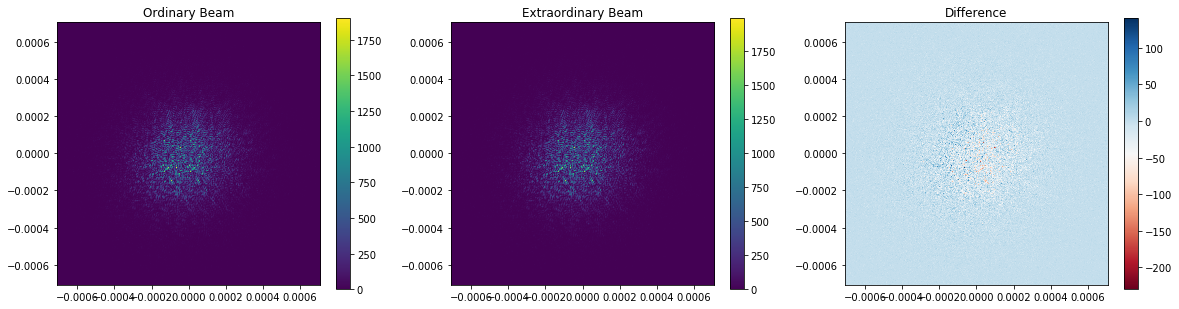

In [18]:
#half waveplate (HWP) positions
#HWP_positions = [0, 45, 22.5, 67.5] # degrees
HWP_positions = np.linspace(0.0,359.0,360)
ims_o = []
ims_e = []

###primary parameters
mag = 5 #Vega magnitude in the band of interest
stokes_vector = [1, 0, 0, 0.]
exposure_time = 0.01 #exposure time in (seconds)

###companion parameters
contrast = 0.9
stokes_ps = [1, 0.3, 0., 0.] #I, Q, U, V
angular_separation = 10 #in (lambda/D)

#(fnc: Wavefront)
    #par: electric_field, wavelength, input_stokes_vector
    #represents the state of light to be propagated through the optical system


wf_planet = Wavefront(telescope_pupil*np.exp(4j* np.pi* pupil_grid.x* angular_separation/ pupil_diameter)
                             , wavelength, input_stokes_vector=stokes_ps)
wf_planet.total_power = number_of_photons(mag, filter_name, collecting_area)*contrast #In (photons/s)

pupil_wavefront = Wavefront(telescope_pupil, wavelength, input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag, filter_name, collecting_area) # in (photons/s)


#(fnc: NoisyDetector) a detector class that has some basic noise properties 
detector_o = NoisyDetector(focal_grid, dark_current_rate=0, read_noise = 0, flat_field = 0, include_photon_noise=True)
detector_e = NoisyDetector(focal_grid, dark_current_rate=0, read_noise = 0, flat_field = 0, include_photon_noise=True)

layer.t = 0.1
# (fnc: LinearPolarizingBeamSplitter) accepts one wavefront and returns two orthogonally linearly polarized wavefronts
    #parameter: polarization_angle
wollaston = LinearPolarizingBeamSplitter(0)
for i in range(10):
    layer.t+=exposure_time
    angle = HWP_positions[i]
    HWP = HalfWavePlate(angle)
    
    star_o, star_e = wollaston(prop(HWP.forward(layer(pupil_wavefront))))
    planet_o, planet_e = wollaston(prop(HWP.forward(layer(wf_planet))))

#(fnc: detector.integrate)
    #par: wavefront, sets amt of power generated per unit time | dt, integration time in units of time
    detector_o.integrate(star_o,exposure_time)
    detector_o.integrate(planet_o,exposure_time)
    detector_e.integrate(star_e,exposure_time)
    detector_e.integrate(planet_e,exposure_time)

    im_o = detector_o.read_out()
    im_e = detector_e.read_out()
    
    ims_o.append(im_o)
    ims_e.append(im_e)

fig,axes = plt.subplots(1,3,figsize=(20,5))

im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
#difference
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu')

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])



720 800
1.0
720 800
0.0
720 800
1.0
720 800
1.0
720 800
0.0
720 800
1.0
720 800
1.0
720 800
0.0
720 800
1.0
720 800
0.0


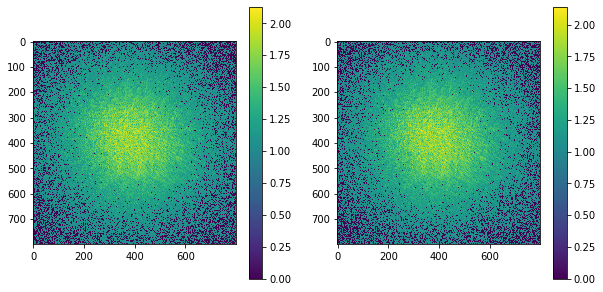

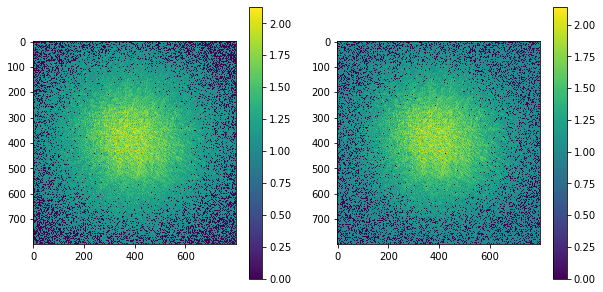

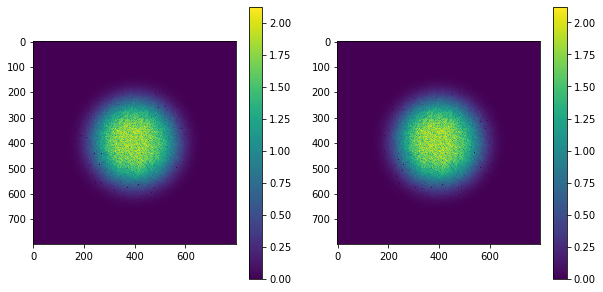

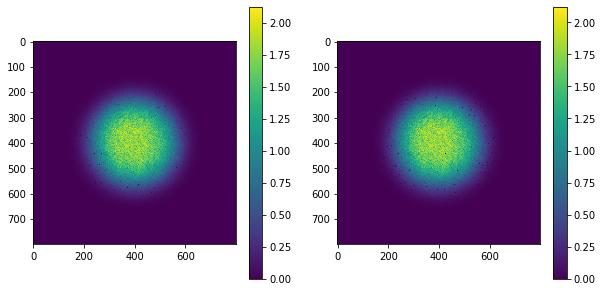

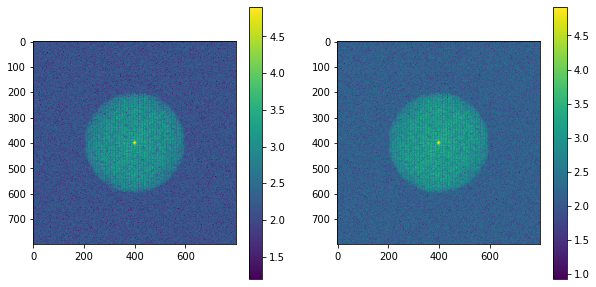

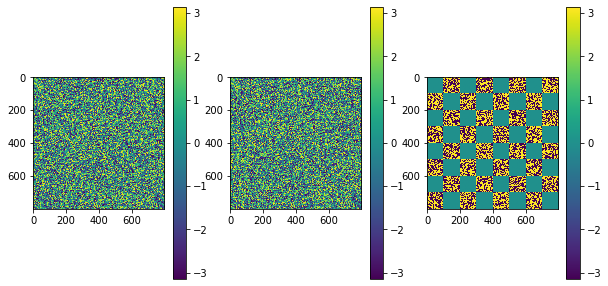

In [19]:
###applying sg to detector read outs, and then taking the fourier transform 

#im_o is ordinary beam detector read out 
npix = np.prod(im_o.shape)
npix2 = int(np.sqrt(npix))

im_o_fts = []
im_e_fts = []

#from above, ims_o = [], ims_o.append(im_o)
for i in range(len(ims_o)):
    im_o = ims_o[i]
    im_e = ims_e[i]
#im_o_fts vs im_o_ft? *
    im_o_ft = im_o.copy().reshape([int(np.sqrt(npix)),int(np.sqrt(npix))])
    im_e_ft = im_e.copy().reshape([int(np.sqrt(npix)),int(np.sqrt(npix))])
    
##adding supergauss window
    from utils import supergauss_hw
    sg = supergauss_hw(100, 4, int(np.sqrt(npix)))

#why were these lines removed? -> these were subtracting the mean of this array of pixels
# from the image to account for background noise, but array/# of pixels (1000) is 
# more than/most of the pixels in the image 
#fix --> a new variable that defines an array sized to achieve desired results, subtract from npix
    ###background subtraction
    #im_o_ft -= np.median(im_o_ft[1000:,1000:])
    #im_e_ft -= np.median(im_e_ft[1000:,1000:])
    
    
 ###background subtraction (creating separate plot)
    im_o_ft_b = im_o_ft.copy()
    im_e_ft_b = im_e_ft.copy()
    
    bpix = npix2 - int(0.1*npix2)
    print(bpix,npix2)
    
    im_o_ft_b -= np.median(im_o_ft[(bpix):,(bpix):])
    im_e_ft_b -= np.median(im_e_ft[(bpix):,(bpix):])
    print(np.median(im_o_ft[(bpix):,(bpix):]))
   

    ##taking fourier transforms##
    FT_o = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im_o_ft * sg)))
    FT_e = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im_e_ft * sg)))
    FT_a = np.fft.fftshift(np.fft.fft2(im_o_ft * sg))
    phase = np.angle(FT_o)
    phase2 = np.angle(FT_a)

    im_o_fts.append(FT_o/FT_o[int(np.sqrt(npix)/2),int(np.sqrt(npix)/2)])
    im_e_fts.append(FT_e/FT_e[int(np.sqrt(npix)/2),int(np.sqrt(npix)/2)])


##creating plots

#detector read out
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_ft)**0.1) #scaling of some sort? --> logarithmic
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_ft)**0.1) 
plt.colorbar()
plt.show()

#detector read out; w/ background subtraction
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_ft_b)**0.1)
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_ft_b)**0.1) 
plt.colorbar()
plt.show()

#supergaussian applied
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_ft * sg)**0.1) 
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_ft * sg)**0.1)
plt.colorbar()
plt.show()

#supergaussian applied; w/ background subtraction
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_ft_b * sg)**0.1) 
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_ft_b * sg)**0.1)
plt.colorbar()
plt.show()

#Fourier transform of sg
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(FT_o)**0.1) 
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(FT_e)**0.1)
plt.colorbar()
plt.show()

f = plt.figure(figsize = (10,5))
f.add_subplot(131)
plt.imshow(phase) 
plt.colorbar()
f.add_subplot(132)
plt.imshow(phase2)
plt.colorbar()
f.add_subplot(133)
plt.imshow(phase - phase2)
plt.colorbar()
plt.show()

#print(npix)


    
    

In [20]:
#determining average FTs and approximating phase as constant slope

#for now assume rho_L and rho_R are 0
rho_L = 0
rho_R = 0 
##(fnc: np.fft.fftfreq) -> returns an array of discrete FT sample frequencies
    #par: n, window length

#N_e --> average number of photons in a single frame
N_e = np.mean([ims_o , ims_e])
print(N_e)

hwps = np.array(HWP_positions)
harmonic = 4.0

#from earlier: R_Q(f_L,f_R,N_e,theta,h) , similarly for R_L

Ru = R_U(np.array(im_o_fts), np.array(im_e_fts), N_e , hwps , harmonic)
Rq = R_Q(np.array(im_o_fts), np.array(im_e_fts), N_e , hwps , harmonic)



32.3923734375


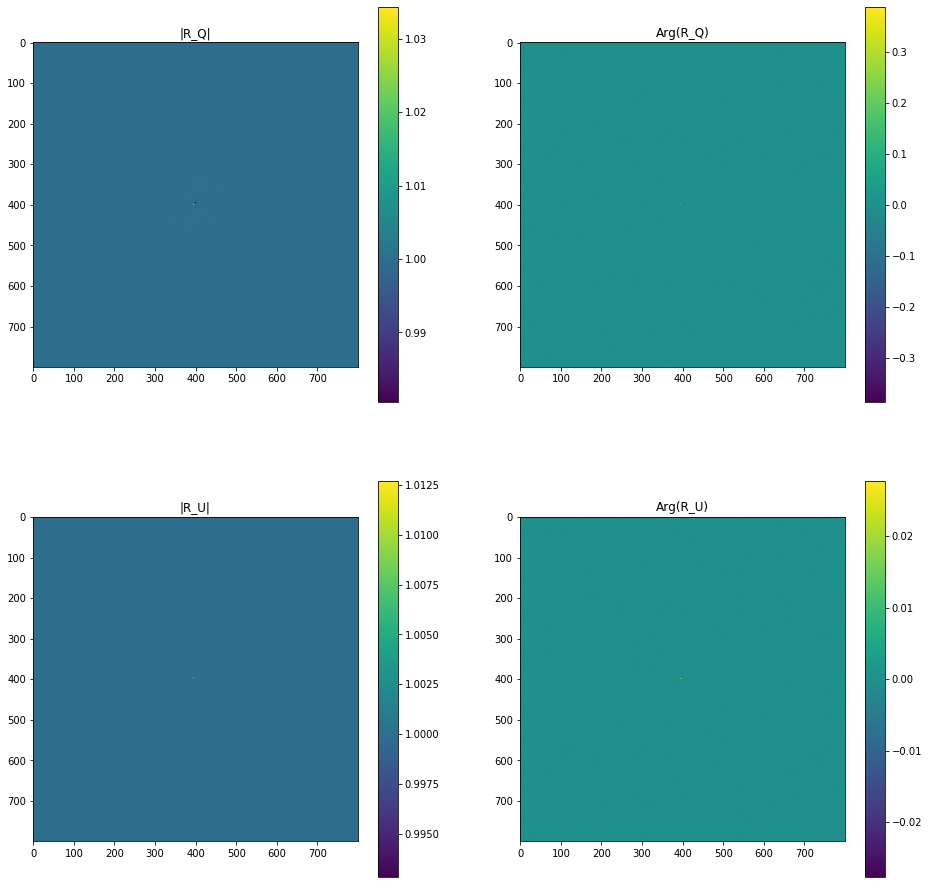

In [21]:
## plotting amplitude and phase for Ru and Rq

f = plt.figure(figsize=(16,16))
f.add_subplot(221)
plt.imshow(np.abs(Rq)) #Rq amplitude
plt.title('|R_Q|')
plt.colorbar()

f.add_subplot(222)
plt.imshow(np.angle(Rq)) #Rq phase
plt.title('Arg(R_Q)')
plt.colorbar()

f.add_subplot(223)
plt.imshow(np.abs(Ru)) #Ru amplitude
plt.title('|R_U|')
plt.colorbar()


f.add_subplot(224)
plt.imshow(np.angle(Ru)) #Rq phase
plt.title('Arg(R_U)') 
plt.colorbar()
plt.show()



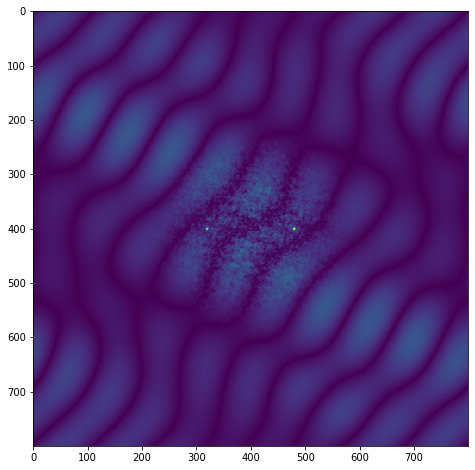

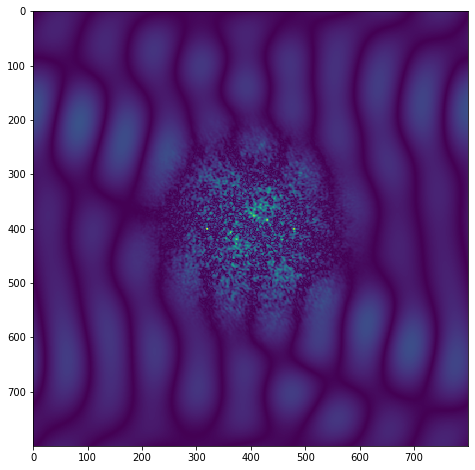

In [22]:
##taking the inverse fourier transforms to determine Q and U

IFT_Q = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(Rq - 1.0)))
f = plt.figure(figsize=(10,8))
#plot abs value of inverse FT (Q and U)
plt.imshow(np.abs(IFT_Q))
plt.show()

IFT_U = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(Ru - 1.0)))
f = plt.figure(figsize=(10,8))
plt.imshow(np.abs(IFT_U))
plt.show()

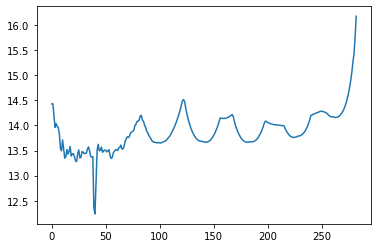

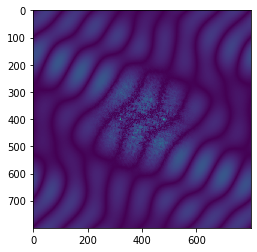

In [23]:
PI = IFT_Q + IFT_U
rad_PI = radial_data(np.abs(PI),annulus_width=2)
plt.plot(range(len(rad_PI.std)),-2.5*np.log10(rad_PI.max))
plt.show()
plt.imshow(np.abs(PI))

   ## Calculate FTs for ordinary and extraordinary beams

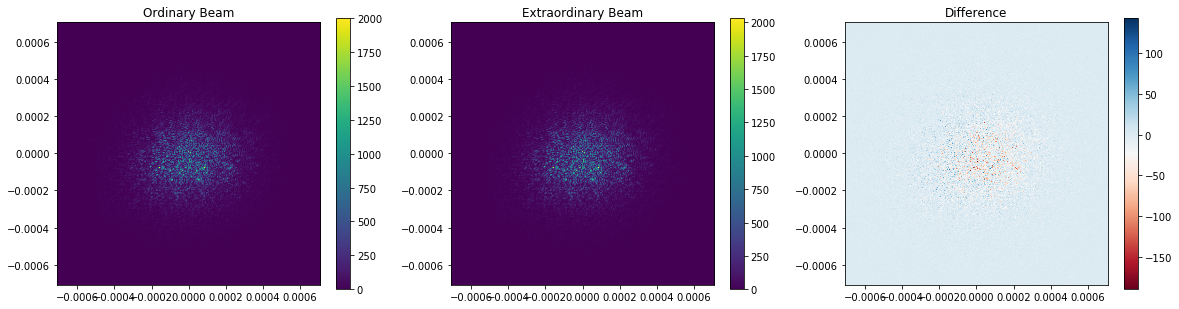

In [24]:
#half waveplate (HWP) positions
#HWP_positions = [0, 45, 22.5, 67.5] # degrees
HWP_positions = np.linspace(0.0,359.0,360)
ims_o = []
ims_e = []

###primary parameters
mag = 5 #Vega magnitude in the band of interest
stokes_vector = [1, 0, 0, 0.]
exposure_time = 0.01 #exposure time in (seconds)

###companion parameters
contrast = 0.9
stokes_ps = [1, 0.3, 0., 0.] #I, Q, U, V
angular_separation = 10 #in (lambda/D)

#(fnc: Wavefront)
    #par: electric_field, wavelength, input_stokes_vector
    #represents the state of light to be propagated through the optical system

electric_field_planet = telescope_pupil * np.exp(4j * np.pi * pupil_grid.x * angular_separation / pupil_diameter)

wf_planet = Wavefront(electric_field_planet, wavelength, input_stokes_vector=stokes_ps)
#(original line) wf_planet = Wavefront(telescope_pupil*
                             #np.exp(4j* np.pi
                             # * pupil_grid.x* angular_separation/ pupil_diameter)
                             #, wavelength, input_stokes_vector=stokes_ps)
wf_planet.total_power = number_of_photons(mag, filter_name, collecting_area)*contrast #In (photons/s)

pupil_wavefront = Wavefront(telescope_pupil, wavelength, input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag, filter_name, collecting_area) # in (photons/s)


#(fnc: NoisyDetector) a detector class that has some basic noise properties 
detector_o = NoisyDetector(focal_grid, dark_current_rate=0, read_noise = 0, flat_field = 0, include_photon_noise=True)
detector_e = NoisyDetector(focal_grid, dark_current_rate=0, read_noise = 0, flat_field = 0, include_photon_noise=True)

layer.t = 0.1
# (fnc: LinearPolarizingBeamSplitter) accepts one wavefront and returns two orthogonally linearly polarized wavefronts
    #parameter: polarization_angle
wollaston = LinearPolarizingBeamSplitter(0)
for i in range(10):
    layer.t+=exposure_time
    angle = HWP_positions[i]
    HWP = HalfWavePlate(angle)
    
    star_o, star_e = wollaston(prop(HWP.forward(layer(pupil_wavefront))))
    planet_o, planet_e = wollaston(prop(HWP.forward(layer(wf_planet))))

#(fnc: detector.integrate)
    #par: wavefront, sets amt of power generated per unit time | dt, integration time in units of time
    detector_o.integrate(star_o,exposure_time)
    detector_o.integrate(planet_o,exposure_time)
    detector_e.integrate(star_e,exposure_time)
    detector_e.integrate(planet_e,exposure_time)

    im_o = detector_o.read_out()
    im_e = detector_e.read_out()
    
    ims_o.append(im_o)
    ims_e.append(im_e)

fig,axes = plt.subplots(1,3,figsize=(20,5))

im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
#difference
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu')

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])

# ? o and e look pretty similar?

720 800
1.0
720 800
1.0
720 800
1.0
720 800
1.0
720 800
0.0
720 800
1.0
720 800
1.0
720 800
0.0
720 800
1.0
720 800
0.0


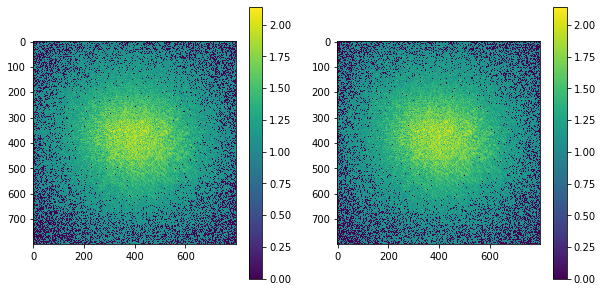

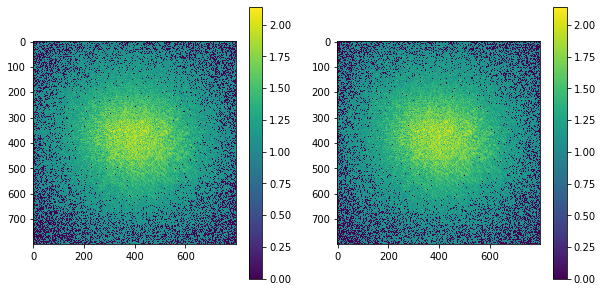

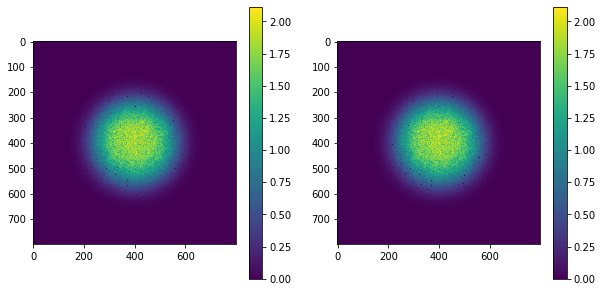

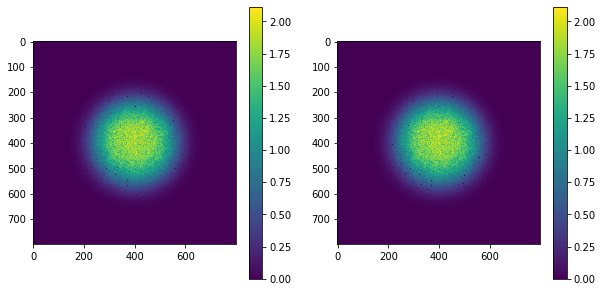

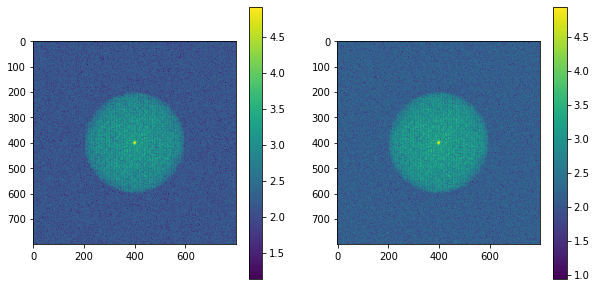

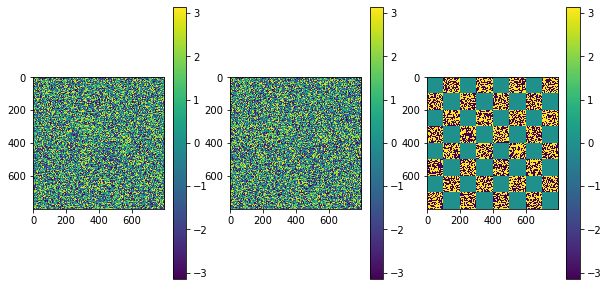

640000


In [25]:
###applying sg to detector read outs, and then taking the fourier transform 

#im_o is ordinary beam detector read out 
npix = np.prod(im_o.shape)
npix2 = int(np.sqrt(npix))

im_o_fts = []
im_e_fts = []

#from above, ims_o = [], ims_o.append(im_o)
for i in range(len(ims_o)):
    im_o = ims_o[i]
    im_e = ims_e[i]
#im_o_fts vs im_o_ft? *
    im_o_ft = im_o.copy().reshape([int(np.sqrt(npix)),int(np.sqrt(npix))])
    im_e_ft = im_e.copy().reshape([int(np.sqrt(npix)),int(np.sqrt(npix))])
    
##adding supergauss window
    from utils import supergauss_hw
    sg = supergauss_hw(100, 4, int(np.sqrt(npix)))

#why were these lines removed? -> these were subtracting the mean of this array of pixels
# from the image to account for background noise, but array/# of pixels (1000) is 
# more than/most of the pixels in the image 
#fix --> a new variable that defines an array sized to achieve desired results, subtract from npix
    ###background subtraction
    #im_o_ft -= np.median(im_o_ft[1000:,1000:])
    #im_e_ft -= np.median(im_e_ft[1000:,1000:])
    
    
 ###background subtraction (creating separate plot)
    im_o_ft_b = im_o_ft.copy()
    im_e_ft_b = im_e_ft.copy()
    
    bpix = npix2 - int(0.1*npix2)
    print(bpix,npix2)
    
    im_o_ft_b -= np.median(im_o_ft[(bpix):,(bpix):])
    im_e_ft_b -= np.median(im_e_ft[(bpix):,(bpix):])
    print(np.median(im_o_ft[(bpix):,(bpix):]))
   
    #no apparent differences in plot?
    #FT_o = np.fft.fftshift(np.fft.fft2(im_o_ft * sg))
    #FT_e = np.fft.fftshift(np.fft.fft2(im_e_ft * sg))

##taking fourier transforms
    FT_o = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im_o_ft * sg)))
    FT_e = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im_e_ft * sg)))
    FT_a = np.fft.fftshift(np.fft.fft2(im_o_ft * sg))
    phase = np.angle(FT_o)
    phase2 = np.angle(FT_a)
# *
    im_o_fts.append(FT_o/FT_o[int(np.sqrt(npix)/2),int(np.sqrt(npix)/2)])
    im_e_fts.append(FT_e/FT_e[int(np.sqrt(npix)/2),int(np.sqrt(npix)/2)])

#also looks the same, recall something about normalizing the fnc? maybe something to do w/ amount of data
    #im_o_fts.append(FT_o)
    #im_e_fts.append(FT_e)
    
##creating plots

#detector read out
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_ft)**0.1) #scaling of some sort? --> logarithmic
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_ft)**0.1) 
plt.colorbar()
plt.show()

#detector read out; w/ background subtraction
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_ft_b)**0.1)
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_ft_b)**0.1) 
plt.colorbar()
plt.show()

#supergaussian applied
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_ft * sg)**0.1) 
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_ft * sg)**0.1)
plt.colorbar()
plt.show()

#supergaussian applied; w/ background subtraction
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_ft_b * sg)**0.1) 
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_ft_b * sg)**0.1)
plt.colorbar()
plt.show()

#Fourier transform of sg
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(FT_o)**0.1) 
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(FT_e)**0.1)
plt.colorbar()
plt.show()

f = plt.figure(figsize = (10,5))
f.add_subplot(131)
plt.imshow(phase) 
plt.colorbar()
f.add_subplot(132)
plt.imshow(phase2)
plt.colorbar()
f.add_subplot(133)
plt.imshow(phase - phase2)
plt.colorbar()
plt.show()

print(npix)


    
    

In [26]:
#determining average FTs and approximating phase as constant slope

#for now assume rho_L and rho_R are 0
rho_L = 0
rho_R = 0 
##(fnc: np.fft.fftfreq) -> returns an array of discrete FT sample frequencies
    #par: n, window length
#what are these two lines for? fs_y/x not used elsewhere
#fs_y = np.fft.fftshift(np.fft.fftfreq(len(im_o_ft)))
#fs_x = np.fft.fftshift(np.fft.fftfreq(len(im_o_ft[0])))

#N_e --> average number of photons in a single frame
N_e = np.mean([ims_o , ims_e])
print(N_e)

hwps = np.array(HWP_positions)
harmonic = 4.0

#from earlier: R_Q(f_L,f_R,N_e,theta,h) , similarly for R_L

Ru = R_U(np.array(im_o_fts), np.array(im_e_fts), N_e , hwps , harmonic)
Rq = R_Q(np.array(im_o_fts), np.array(im_e_fts), N_e , hwps , harmonic)



32.393036640625


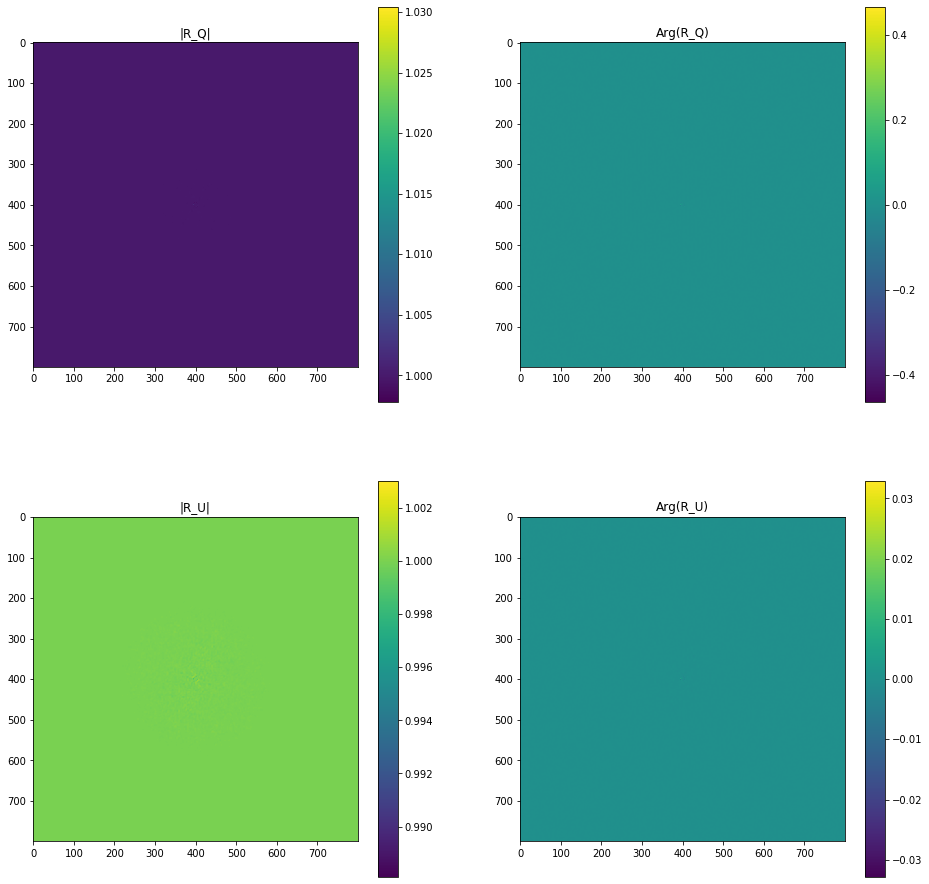

In [27]:
## plotting amplitude and phase for Ru and Rq

mx_qa = np.max(np.abs(Rq)[350:450, 350:450])
mn_qa = np.min(np.abs(Rq)[350:400, 350:450])


#original
#f = plt.figure(figsize=(16,16))
#f.add_subplot(221)
#plt.imshow(np.abs(Rq)) #Rq amplitude
#plt.title('|R_Q|')
#plt.colorbar()

#adjusted colorbar?
f = plt.figure(figsize=(16,16))
f.add_subplot(221)
plt.imshow(np.abs(Rq)**0.1) #Rq amplitude
plt.title('|R_Q|')
plt.colorbar()

f.add_subplot(222)
plt.imshow(np.angle(Rq)) #Rq phase
plt.title('Arg(R_Q)')
plt.colorbar()

f.add_subplot(223)
plt.imshow(np.abs(Ru)) #Ru amplitude
plt.title('|R_U|')
plt.colorbar()


f.add_subplot(224)
plt.imshow(np.angle(Ru)) #Rq phase
plt.title('Arg(R_U)') 
plt.colorbar()
plt.show()



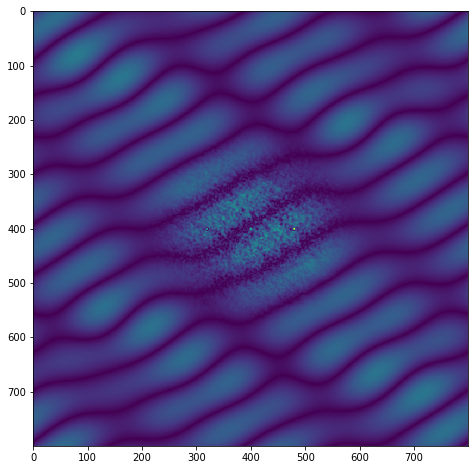

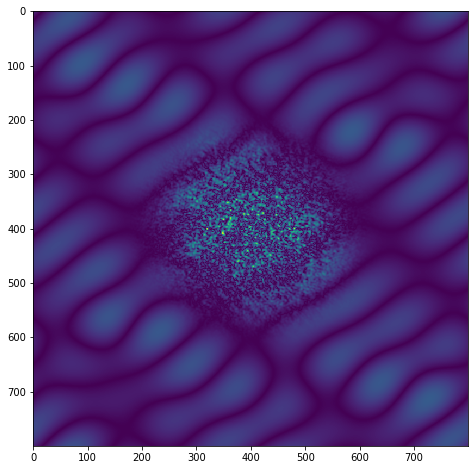

In [28]:
##taking the inverse fourier transforms to determine Q and U

#MNRAS 2019 - before taking the inverse FT multiplied Q and U by the telescope's (OTF) diffraction optical transfer function
IFT_Q = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(Rq - 1.0)))
f = plt.figure(figsize=(10,8))
#plot abs value of inverse FT (Q and U)
plt.imshow(np.abs(IFT_Q))
plt.show()

IFT_U = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(Ru - 1.0)))
f = plt.figure(figsize=(10,8))
plt.imshow(np.abs(IFT_U))
plt.show()

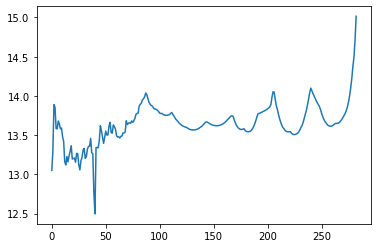

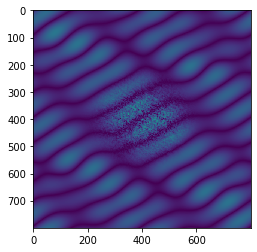

In [29]:
PI = IFT_Q + IFT_U
rad_PI = radial_data(np.abs(PI),annulus_width=2)
plt.plot(range(len(rad_PI.std)),-2.5*np.log10(rad_PI.max))
plt.show()
plt.imshow(np.abs(PI))